In [1]:
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("APL_Logistics_features.csv")
print("Data loaded. Shape:", df.shape)


Data loaded. Shape: (180519, 35)


In [3]:
# Load the XGBoost model trained in 03_model_training
xgb_clf = joblib.load("APL_Logistics_best_model_xgb.pkl")
print("Model loaded successfully")


Model loaded successfully


In [4]:
feature_columns = joblib.load("feature_columns.pkl")
print("Features used for training:", feature_columns)


Features used for training: ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Category Name', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State', 'Department Name', 'Market', 'Order City', 'Order Country', 'Order Region', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Price', 'Shipping_Pressure_Index', 'Shipping_Mode_Express', 'Regional_Congestion_Index', 'Order_Complexity_Score']


In [5]:
# Keep only columns used in training
X = df[feature_columns]
print("X shape after alignment:", X.shape)


X shape after alignment: (180519, 27)


In [6]:
# Predict probability of late delivery (class 1)
df['Late_Delivery_Prob'] = xgb_clf.predict_proba(X)[:,1]
df[['Late_Delivery_Prob']].head()


,Late_Delivery_Prob
0,0.944519
1,0.000538
2,0.000595
3,0.949470
4,0.953457


In [7]:
# Define risk buckets
def risk_category(prob):
    if prob < 0.3:
        return "Low Risk"
    elif prob < 0.7:
        return "Medium Risk"
    else:
        return "High Risk"

# Apply to dataframe
df['Risk_Category'] = df['Late_Delivery_Prob'].apply(risk_category)
df[['Late_Delivery_Prob', 'Risk_Category']].head(10)


,Late_Delivery_Prob,Risk_Category
0,0.944519,High Risk
1,0.000538,Low Risk
2,0.000595,Low Risk
3,0.949470,High Risk
4,0.953457,High Risk
5,0.943683,High Risk
6,0.000887,Low Risk
7,0.000876,Low Risk
8,0.000682,Low Risk
9,0.000789,Low Risk


High Risk      0.570328
Low Risk       0.427323
Medium Risk    0.002349
Name: Risk_Category, dtype: float64


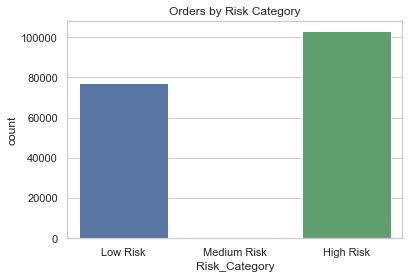

In [8]:
print(df['Risk_Category'].value_counts(normalize=True))

# Plot distribution
sns.countplot(x='Risk_Category', data=df, order=["Low Risk","Medium Risk","High Risk"])
plt.title("Orders by Risk Category")
plt.show()


In [15]:
df['Order_ID'] = df.index
df[['Late_Delivery_Prob', 'Risk_Category'] + feature_columns].to_csv(
    "APL_Logistics_orders_with_risk.csv", index=False
)
print("Orders with risk probabilities saved successfully.")


Orders with risk probabilities saved successfully.


In [10]:
# Filter only High Risk orders
high_risk_orders = df[df['Risk_Category'] == "High Risk"]

print(f"Total High Risk orders: {high_risk_orders.shape[0]}")
high_risk_orders.head(10)


Total High Risk orders: 102955


,ï»¿Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order State,Order Status,Product Price,Shipping Mode,Shipping_Pressure_Index,Shipping_Mode_Express,Regional_Congestion_Index,Order_Complexity_Score,Late_Delivery_Prob,Risk_Category
0,1,6,4,159.69,472.45,1,1,9,10,61,...,610,2,99.99,3,1.0,0,7731,499.95,0.944519,High Risk
3,1,6,4,-41.89,175.99,1,1,48,46,276,...,741,2,199.99,3,0.2,0,6915,199.99,0.949470,High Risk
4,1,6,4,10.00,40.00,1,1,24,47,276,...,741,2,50.00,3,0.2,0,6915,50.00,0.953457,High Risk
5,1,6,4,105.63,290.98,1,1,43,9,276,...,741,2,299.98,3,0.2,0,6915,299.98,0.943683,High Risk
29,1,5,4,-445.21,251.96,1,1,17,12,454,...,664,2,59.99,3,1.0,0,6009,299.95,0.913837,High Risk
33,1,2,1,-41.77,56.99,1,1,17,12,454,...,788,2,59.99,0,0.5,0,14935,59.99,0.908132,High Risk
34,1,2,1,48.66,143.98,1,1,17,12,454,...,788,2,59.99,0,1.5,0,14935,179.97,0.916171,High Risk
35,1,2,1,59.39,134.98,1,1,17,12,454,...,788,2,59.99,0,1.5,0,14935,179.97,0.908080,High Risk
36,1,2,1,26.99,119.95,1,1,40,0,454,...,788,2,24.99,0,2.5,0,14935,124.95,0.926133,High Risk
37,1,1,0,3.37,18.74,1,1,40,0,454,...,893,2,24.99,1,1.0,0,8318,24.99,0.930812,High Risk


In [11]:
# Sort High Risk orders by probability descending
top_high_risk = high_risk_orders.sort_values(
    by='Late_Delivery_Prob', ascending=False
).head(20)

top_high_risk[['Late_Delivery_Prob', 'Risk_Category', 'Order Item Quantity', 'Order Region', 'Customer City']]


,Late_Delivery_Prob,Risk_Category,Order Item Quantity,Order Region,Customer City
57268,0.998989,High Risk,5,1,509
91955,0.998862,High Risk,2,1,522
135267,0.998571,High Risk,5,21,522
78208,0.998542,High Risk,1,1,522
77138,0.998416,High Risk,1,3,533
45917,0.998370,High Risk,1,22,552
45909,0.998284,High Risk,2,22,552
55861,0.998261,High Risk,1,3,552
45908,0.998155,High Risk,1,22,552
84060,0.998000,High Risk,5,17,509


In [12]:
top_high_risk.to_csv("Top_High_Risk_Orders.csv", index=False)
print("Top 20 High Risk orders saved to Top_High_Risk_Orders.csv")


Top 20 High Risk orders saved to Top_High_Risk_Orders.csv


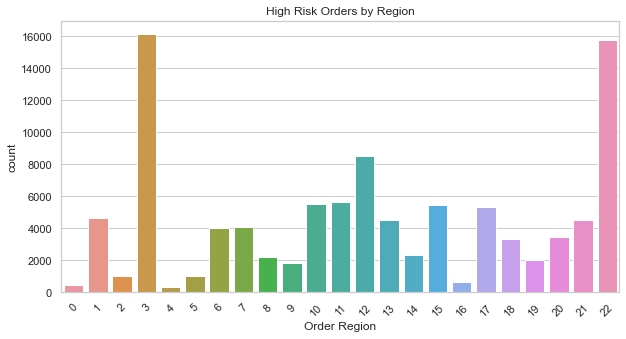

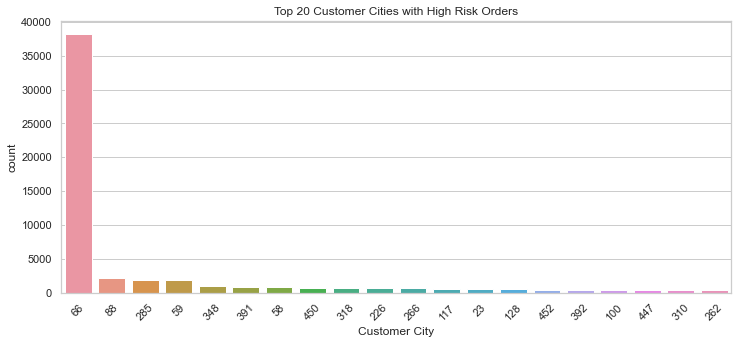

In [13]:
# High Risk by Region
plt.figure(figsize=(10,5))
sns.countplot(x='Order Region', data=high_risk_orders)
plt.title("High Risk Orders by Region")
plt.xticks(rotation=45)
plt.show()

# High Risk by Customer City
plt.figure(figsize=(12,5))
sns.countplot(x='Customer City', data=high_risk_orders,
              order=high_risk_orders['Customer City'].value_counts().index[:20])
plt.title("Top 20 Customer Cities with High Risk Orders")
plt.xticks(rotation=45)
plt.show()


In [16]:
df.columns

Index(['ï»¿Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Department Id', 'Department Name', 'Market', 'Order City',
       'Order Country', 'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Price', 'Shipping Mode', 'Shipping_Pressure_Index',
       'Shipping_Mode_Express', 'Regional_Congestion_Index',
       'Order_Complexity_Score', 'Late_Delivery_Prob', 'Risk_Category',
       'Order_ID'],
      dtype='object')

In [17]:
dashboard_df = df[[
    'Order_ID',
    'Customer City',
    'Order Region',
    'Shipping Mode',
    'Late_Delivery_Prob',
    'Risk_Category'
]]

# Optional: add Top Risk Drivers from SHAP
# dashboard_df['Top_Driver_1'] = ...
# dashboard_df['Top_Driver_2'] = ...
# dashboard_df['Top_Driver_3'] = ...

dashboard_df.to_csv("APL_Logistics_Dashboard_Data.csv", index=False)
print("Dashboard-ready dataset saved!")

Dashboard-ready dataset saved!
